# Head-specific compression
In this notebook, we demonstrate how to implement head-specific compression using an example of Ada-SnapKV from (AdaKV)[arxiv.org/abs/2407.11550]. Before proceeding, please refer to the file `new_press.ipynb` to understand how standard compression works.

### Key observation

Different attention heads within LLMs exhibit significant disparities in their attention patterns, such as varying degrees of attention concentration. This enables us to distribute the overall budget across different attention heads strategically. For example, according to AdaKV, we allocate more budget to attention heads with distributed attention and reduce the compression budget for heads exhibiting concentrated attention.

### How to Achieve Head-specific Compression in Practice?
Head-specific compression offers significant advantages under the same budget compared to standard compression. However, it introduces challenges in managing cache length differences across heads. To address these challenges, we provide a solution based on a flattened cache layout `DynamicCacheSplitHeadFlatten`, complemented by:

* Custom CUDA kernels for cache update operations: `update_flatten_klenN_view`
* Flash Attention techniques supporting variable-length cache computations:  `flash_attn_varlen_func`


In [3]:
import torch
from torch import nn
from transformers import pipeline
from kvpress import BasePress, AdaSnapKVPress

context = "In this step-by-step guide, you will learn how to create a new press in kvpress !"
question = "\nWhat is the purpose of this guide?"

## Overview of How to Use Head-Specific Compression
Here’s an example using Ada-SnapKV(AdaKV) to illustrate the process:

1. Replace the Standard Flash Attention with Variable-Length Flash Attention **Before loading the LLM**.
2. Instantiate a head-specific compression (e.g. Ada-SnapKV ) and Integrate it into the Pipeline


In [ ]:

from kvpress.ada_attn import replace_var_flash_attn


device = "cuda:0"
ckpt = "Meta-Llama-3.1-8B-Instruct"

# [Important] replace the vanilla flash attention with the flash_attn_varlen_func 
attn_implementation = "flash_attention_2"
replace_var_flash_attn(model=ckpt)

# window_size 2 for eaiser demonstration
ada_snapkv_press = AdaSnapKVPress()
ada_snapkv_press.compression_ratio = 0.5
ada_snapkv_press.window_size=2

# construct the pipeline
pipe = pipeline("kv-press-text-generation", model=ckpt, device=device,torch_dtype="auto", model_kwargs={"attn_implementation":attn_implementation})


You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Replacing vanilla flash attention in /raid/share_files/models/Meta-Llama-3.1-8B-Instruct with flash_attn_varlen_func for head-specific compression support.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
# generate text
tokens = pipe.tokenizer(context, return_tensors="pt").to(device)
print("Answer:",pipe(context, question=question,press=ada_snapkv_press)["answer"])

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


Answer: The purpose of this guide is to teach users how to create a new press in kvpress, which is likely a software or tool used for creating and managing press releases or other types of content.


## A Closer Look at the Role of Flattened Cache Layout in Head-Specific Compression

regular cache layout: [bsz, head_num, seqlen, head_dim] -> flattened cache layout: [ (seqlen in head1, bsz1) + (seqlen in head2, bsz1) + (seqlen in head3, bsz1) ... + (seqlen in head_num, bsz), head_dim]



In [6]:
from kvpress.ada_cache import DynamicCacheSplitHeadFlatten

# DynamicCacheSplitHeadFlatten Class is used to flatten the cache for all heads
flatten_cache = DynamicCacheSplitHeadFlatten()
with torch.no_grad():
    outputs_without_press = pipe.model(**tokens, past_key_values=flatten_cache)

flatten_cache = DynamicCacheSplitHeadFlatten()
with torch.no_grad(), ada_snapkv_press(pipe.model):
    output_with_press = pipe.model(**tokens, past_key_values=flatten_cache)

print(f"There are {len(outputs_without_press.past_key_values.metadata_list[0].head_lens)} heads with the same lengths of cached tokens: {outputs_without_press.past_key_values.metadata_list[0].head_lens}")
print(f"Flatten Cache shape without press: {outputs_without_press.past_key_values.key_cache[0].shape}\n")

print(f"After head-specific compression, there are {len(output_with_press.past_key_values.metadata_list[0].head_lens)} heads with different lengths of cached tokens: {output_with_press.past_key_values.metadata_list[0].head_lens}")
print(f"Flatten Cache shape with press: {output_with_press.past_key_values.key_cache[0].shape}\n")

compress_ratio = 1 - output_with_press.past_key_values.key_cache[0].shape[0] / outputs_without_press.past_key_values.key_cache[0].shape[0]

print(f"Overall compression ratio: 1 - sum({outputs_without_press.past_key_values.metadata_list[0].head_lens.cpu().tolist()})/sum({output_with_press.past_key_values.metadata_list[0].head_lens.cpu().tolist()}) = {compress_ratio}\n")

# The `KVPressTextGenerationPipeline` simply applies the `press` as above on the context tokens (see `_forward` method for more details).
print("Answer:",pipe(context, question=question, press=ada_snapkv_press)["answer"])

There are 8 heads with the same lengths of cached tokens: tensor([21, 21, 21, 21, 21, 21, 21, 21], device='cuda:0', dtype=torch.int32)
Flatten Cache shape without press: torch.Size([168, 128])

After head-specific compression, there are 8 heads with different lengths of cached tokens: tensor([ 9, 12, 11, 14,  5, 15, 13,  5], device='cuda:0', dtype=torch.int32)
Flatten Cache shape with press: torch.Size([84, 128])

Overall compression ratio: 1 - sum([21, 21, 21, 21, 21, 21, 21, 21])/sum([9, 12, 11, 14, 5, 15, 13, 5]) = 0.5

Answer: The purpose of this guide is to teach users how to create a new press in kvpress, which is likely a software or tool used for creating and managing press releases or other types of content.


## Create your own head-spefic cache compression method
1. [What You Need to Do]: Implement a new cache compression method by inheriting from the `AdaBasePress` class. For the new head-specific compression method, it is recommended to generate a masked score to directly mask the KV cache pairs you wish to retain in each head, setting their score to the maximum value.
3. The `AdaBasePress` class `forward_hook` will, by default, retain the highest-scoring cache pairs across all heads within a layer, updating the flattened cache and corresponding metadata.

Below, MyAdaPress demonstrates a simple example that retains the KV cache in heads 1 and 2 in full, while the other heads retain cache according to the StreamingLLM method (i.e., keeping the 4 sink token caches and the caches within the recent window).

In [9]:
from kvpress.presses.ada_scorer_press import AdaScorerPress


class MyAdaPress(AdaScorerPress):
    def score(
        self,
        module: nn.Module,
        hidden_states: torch.Tensor,
        keys: torch.Tensor,
        values: torch.Tensor,
        attentions: torch.Tensor,
        kwargs,
    ) -> torch.Tensor:
        
        cache_metadata = kwargs.get("metadata", None)
        assert cache_metadata is not None, "cache_metadata is required for AdaPress"

        # Convert to (bsz, num_key_value_heads, q_len, head_dim) for easier scoring
        # Since this is the first compression, we can easily flatten the key and value head dimensions for score computation
        # In multi-turn compression scenarios, extra care is needed as the key and value head dimensions may not be restructured
        keys = keys.view(cache_metadata.bsz, cache_metadata.num_key_value_heads, -1, keys.shape[-1])
        values = values.view(cache_metadata.bsz, cache_metadata.num_key_value_heads, -1, keys.shape[-1])
        seq_len = keys.shape[-2]

        # initialize scores
        scores = torch.arange(seq_len, device=keys.device).float()
        scores = scores.unsqueeze(0).unsqueeze(0).repeat(cache_metadata.bsz, cache_metadata.num_key_value_heads, 1)

        max_value = torch.finfo(scores.dtype).max

        # mask for attn sink
        scores[:,:,:4] = max_value

        # mask the scores for all cache in head1 and head2
        scores[:, :2, :] = max_value

        flattened_scores = scores.view(cache_metadata.bsz, -1)

        
        return flattened_scores


press = MyAdaPress(0.5)

flatten_cache = DynamicCacheSplitHeadFlatten()
with torch.no_grad():
    outputs_without_press = pipe.model(**tokens, past_key_values=flatten_cache)

flatten_cache = DynamicCacheSplitHeadFlatten()
with torch.no_grad(), press(pipe.model):
    output_with_press = pipe.model(**tokens, past_key_values=flatten_cache)

print(f"There are {len(outputs_without_press.past_key_values.metadata_list[0].head_lens)} heads with the same lengths of cached tokens: {outputs_without_press.past_key_values.metadata_list[0].head_lens}")
print(f"Flatten Cache shape without press: {outputs_without_press.past_key_values.key_cache[0].shape}\n")

print(f"After head-specific compression, there are {len(output_with_press.past_key_values.metadata_list[0].head_lens)} heads with different lengths of cached tokens: {output_with_press.past_key_values.metadata_list[0].head_lens}")
print(f"Flatten Cache shape with press: {output_with_press.past_key_values.key_cache[0].shape}\n")

compress_ratio = 1 - output_with_press.past_key_values.key_cache[0].shape[0] / outputs_without_press.past_key_values.key_cache[0].shape[0]
print(f"Overall compression ratio: 1 - sum({outputs_without_press.past_key_values.metadata_list[0].head_lens.cpu().tolist()})/sum({output_with_press.past_key_values.metadata_list[0].head_lens.cpu().tolist()}) = {compress_ratio}\n")

print("Answer:", pipe(context, question=question, press=press)["answer"])

There are 8 heads with the same lengths of cached tokens: tensor([21, 21, 21, 21, 21, 21, 21, 21], device='cuda:0', dtype=torch.int32)
Flatten Cache shape without press: torch.Size([168, 128])

After head-specific compression, there are 8 heads with different lengths of cached tokens: tensor([21, 21,  7,  7,  7,  7,  7,  7], device='cuda:0', dtype=torch.int32)
Flatten Cache shape with press: torch.Size([84, 128])

Overall compression ratio: 1 - sum([21, 21, 21, 21, 21, 21, 21, 21])/sum([21, 21, 7, 7, 7, 7, 7, 7]) = 0.5

Answer: This guide is intended to help users create a new press in kvpress, which is a software for creating and managing press releases. The purpose of this guide is to provide step-by-step instructions on how to create a new press in kvpress, allowing


## Comparison of Ada-SnapKV (AdaKV) and SnapKV on the 4K Ruler Benchmark (Llama-3.1-8B-Instruct)

In [10]:
import re
import pandas as pd

import matplotlib.pyplot as plt

from io import StringIO

csv_data = """
File Name,cwe,fwe,niah_multikey_1,niah_multikey_2,niah_multikey_3,niah_multiquery,niah_multivalue,niah_single_1,niah_single_2,niah_single_3,qa_1,qa_2,vt,average_score
4090_ruler_4096_Meta-Llama-3.1-8B-Instruct_snapkv_win64p5_0.3_compressed_questions.json,99.24,93.2,99.8,100.0,98.2,99.85,99.55,100.0,100.0,81.2,87.4,61.8,98.92,93.78153846153847
4090_ruler_4096_Meta-Llama-3.1-8B-Instruct_ada_snapkv_win64p5_0.3_compressed_questions.json,99.4,94.67,99.8,100.0,99.6,99.85,99.85,100.0,100.0,90.8,87.8,62.6,99.88,94.9423076923077
4090_ruler_4096_Meta-Llama-3.1-8B-Instruct_ada_snapkv_win64p5_0.7_compressed_questions.json,97.04,90.0,99.8,98.4,64.0,99.9,98.35,100.0,100.0,10.0,88.2,61.6,97.64,84.99461538461539
a100_ruler_4096_Meta-Llama-3.1-8B-Instruct_snapkv_win64p5_0.3.json,99.44,94.07,98.2,79.0,48.2,92.95,87.0,99.2,99.8,10.2,81.6,57.2,91.44,79.86923076923077
a100_ruler_4096_Meta-Llama-3.1-8B-Instruct_ada_snapkv_win64p5_0.3.json,99.44,94.4,99.4,99.0,84.8,99.35,97.2,99.8,100.0,15.6,83.2,57.2,99.64,86.84846153846155
a100_ruler_4096_Meta-Llama-3.1-8B-Instruct_ada_snapkv_win64p5_0.1.json,99.7,94.47,99.8,100.0,99.0,99.9,99.9,100.0,100.0,65.4,87.6,62.2,99.92,92.91461538461539
4090_ruler_4096_Meta-Llama-3.1-8B-Instruct_snapkv_win64p5_0.5_compressed_questions.json,97.82,90.07,99.8,99.2,85.6,99.95,99.2,100.0,100.0,37.0,87.6,61.8,97.72,88.9046153846154
a100_ruler_4096_Meta-Llama-3.1-8B-Instruct_snapkv_win64p5_0.1.json,99.7,94.87,99.6,98.0,85.2,99.6,98.85,99.2,100.0,21.6,87.2,60.0,96.44,87.7123076923077
4090_ruler_4096_Meta-Llama-3.1-8B-Instruct_snapkv_win64p5_0.1_compressed_questions.json,99.66,94.87,99.8,100.0,99.8,99.9,99.75,100.0,100.0,99.0,87.8,62.6,99.6,95.59846153846152
4090_ruler_4096_Meta-Llama-3.1-8B-Instruct_snapkv_win64p5_0.5.json,98.2,92.13,85.6,53.6,20.2,76.2,72.4,96.8,95.2,5.8,75.8,52.4,82.68,69.76999999999998
4090_ruler_4096_Meta-Llama-3.1-8B-Instruct_snapkv_win64p5_0.7.json,90.32,87.33,43.6,22.6,4.0,34.6,32.0,83.8,65.6,2.6,61.6,41.4,64.76,48.785384615384615
4090_ruler_4096_Meta-Llama-3.1-8B-Instruct_ada_snapkv_win64p5_0.5_compressed_questions.json,99.18,93.47,99.8,100.0,96.2,99.95,99.3,100.0,100.0,48.4,87.6,62.0,99.4,91.17692307692309
4090_ruler_4096_Meta-Llama-3.1-8B-Instruct_snapkv_win64p5_0.7_compressed_questions.json,88.06,81.33,99.8,96.2,39.6,99.9,98.3,100.0,100.0,8.6,88.2,61.2,91.96,81.01153846153846
4090_ruler_4096_Meta-Llama-3.1-8B-Instruct_ada_snapkv_win64p5_0.1_compressed_questions.json,99.64,94.87,99.8,100.0,99.8,99.9,99.9,100.0,100.0,99.8,87.8,62.8,99.92,95.71000000000001
4090_ruler_4096_Meta-Llama-3.1-8B-Instruct_ada_snapkv_win64p5_0.5.json,99.2,94.73,89.6,82.8,47.6,86.1,78.5,99.6,98.2,7.6,77.2,52.6,96.48,77.70846153846155
4090_ruler_4096_Meta-Llama-3.1-8B-Instruct_ada_snapkv_win64p5_0.7.json,97.74,93.33,43.6,43.8,13.8,29.35,28.8,94.8,70.0,2.6,64.6,43.4,86.2,54.77076923076924

"""

data = StringIO(csv_data)

df = pd.read_csv(data)
df['compression_rate'] = df['File Name'].apply(lambda x: float(re.search(r'_(\d+\.\d+)(?=(_compressed_questions)?\.json$)', x).group(1)))

df_w_question = df[df['File Name'].str.contains('compressed_questions')]
df_wo_question = df[~df['File Name'].str.contains('compressed_questions')]
ada_snapekv_w_question = df_w_question[df_w_question['File Name'].str.contains('ada_snapkv')].sort_values(by='compression_rate')
snapekv_w_question = df_w_question[~df_w_question['File Name'].str.contains('ada_snapkv')].sort_values(by='compression_rate')
ada_snapekv_wo_question = df_wo_question[df_wo_question['File Name'].str.contains('ada_snapkv')].sort_values(by='compression_rate')
snapekv_wo_question = df_wo_question[~df_wo_question['File Name'].str.contains('ada_snapkv')].sort_values(by='compression_rate')

### Average Score Comparation

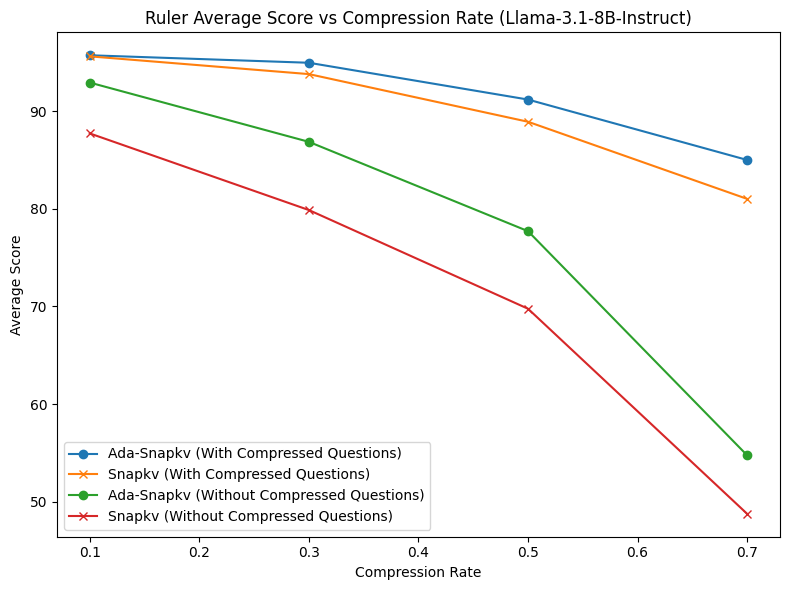

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(ada_snapekv_w_question['compression_rate'], ada_snapekv_w_question['average_score'], label='Ada-Snapkv (With Compressed Questions)', marker='o')
plt.plot(snapekv_w_question['compression_rate'], snapekv_w_question['average_score'], label='Snapkv (With Compressed Questions)', marker='x')
plt.plot(ada_snapekv_wo_question['compression_rate'], ada_snapekv_wo_question['average_score'], label='Ada-Snapkv (Without Compressed Questions)', marker='o')
plt.plot(snapekv_wo_question['compression_rate'], snapekv_wo_question['average_score'], label='Snapkv (Without Compressed Questions)', marker='x')
plt.title('Ruler Average Score vs Compression Rate (Llama-3.1-8B-Instruct)')
plt.xlabel('Compression Rate')
plt.ylabel('Average Score')
plt.legend()
plt.tight_layout()
plt.show()

## Score Comparison Across All Datasets

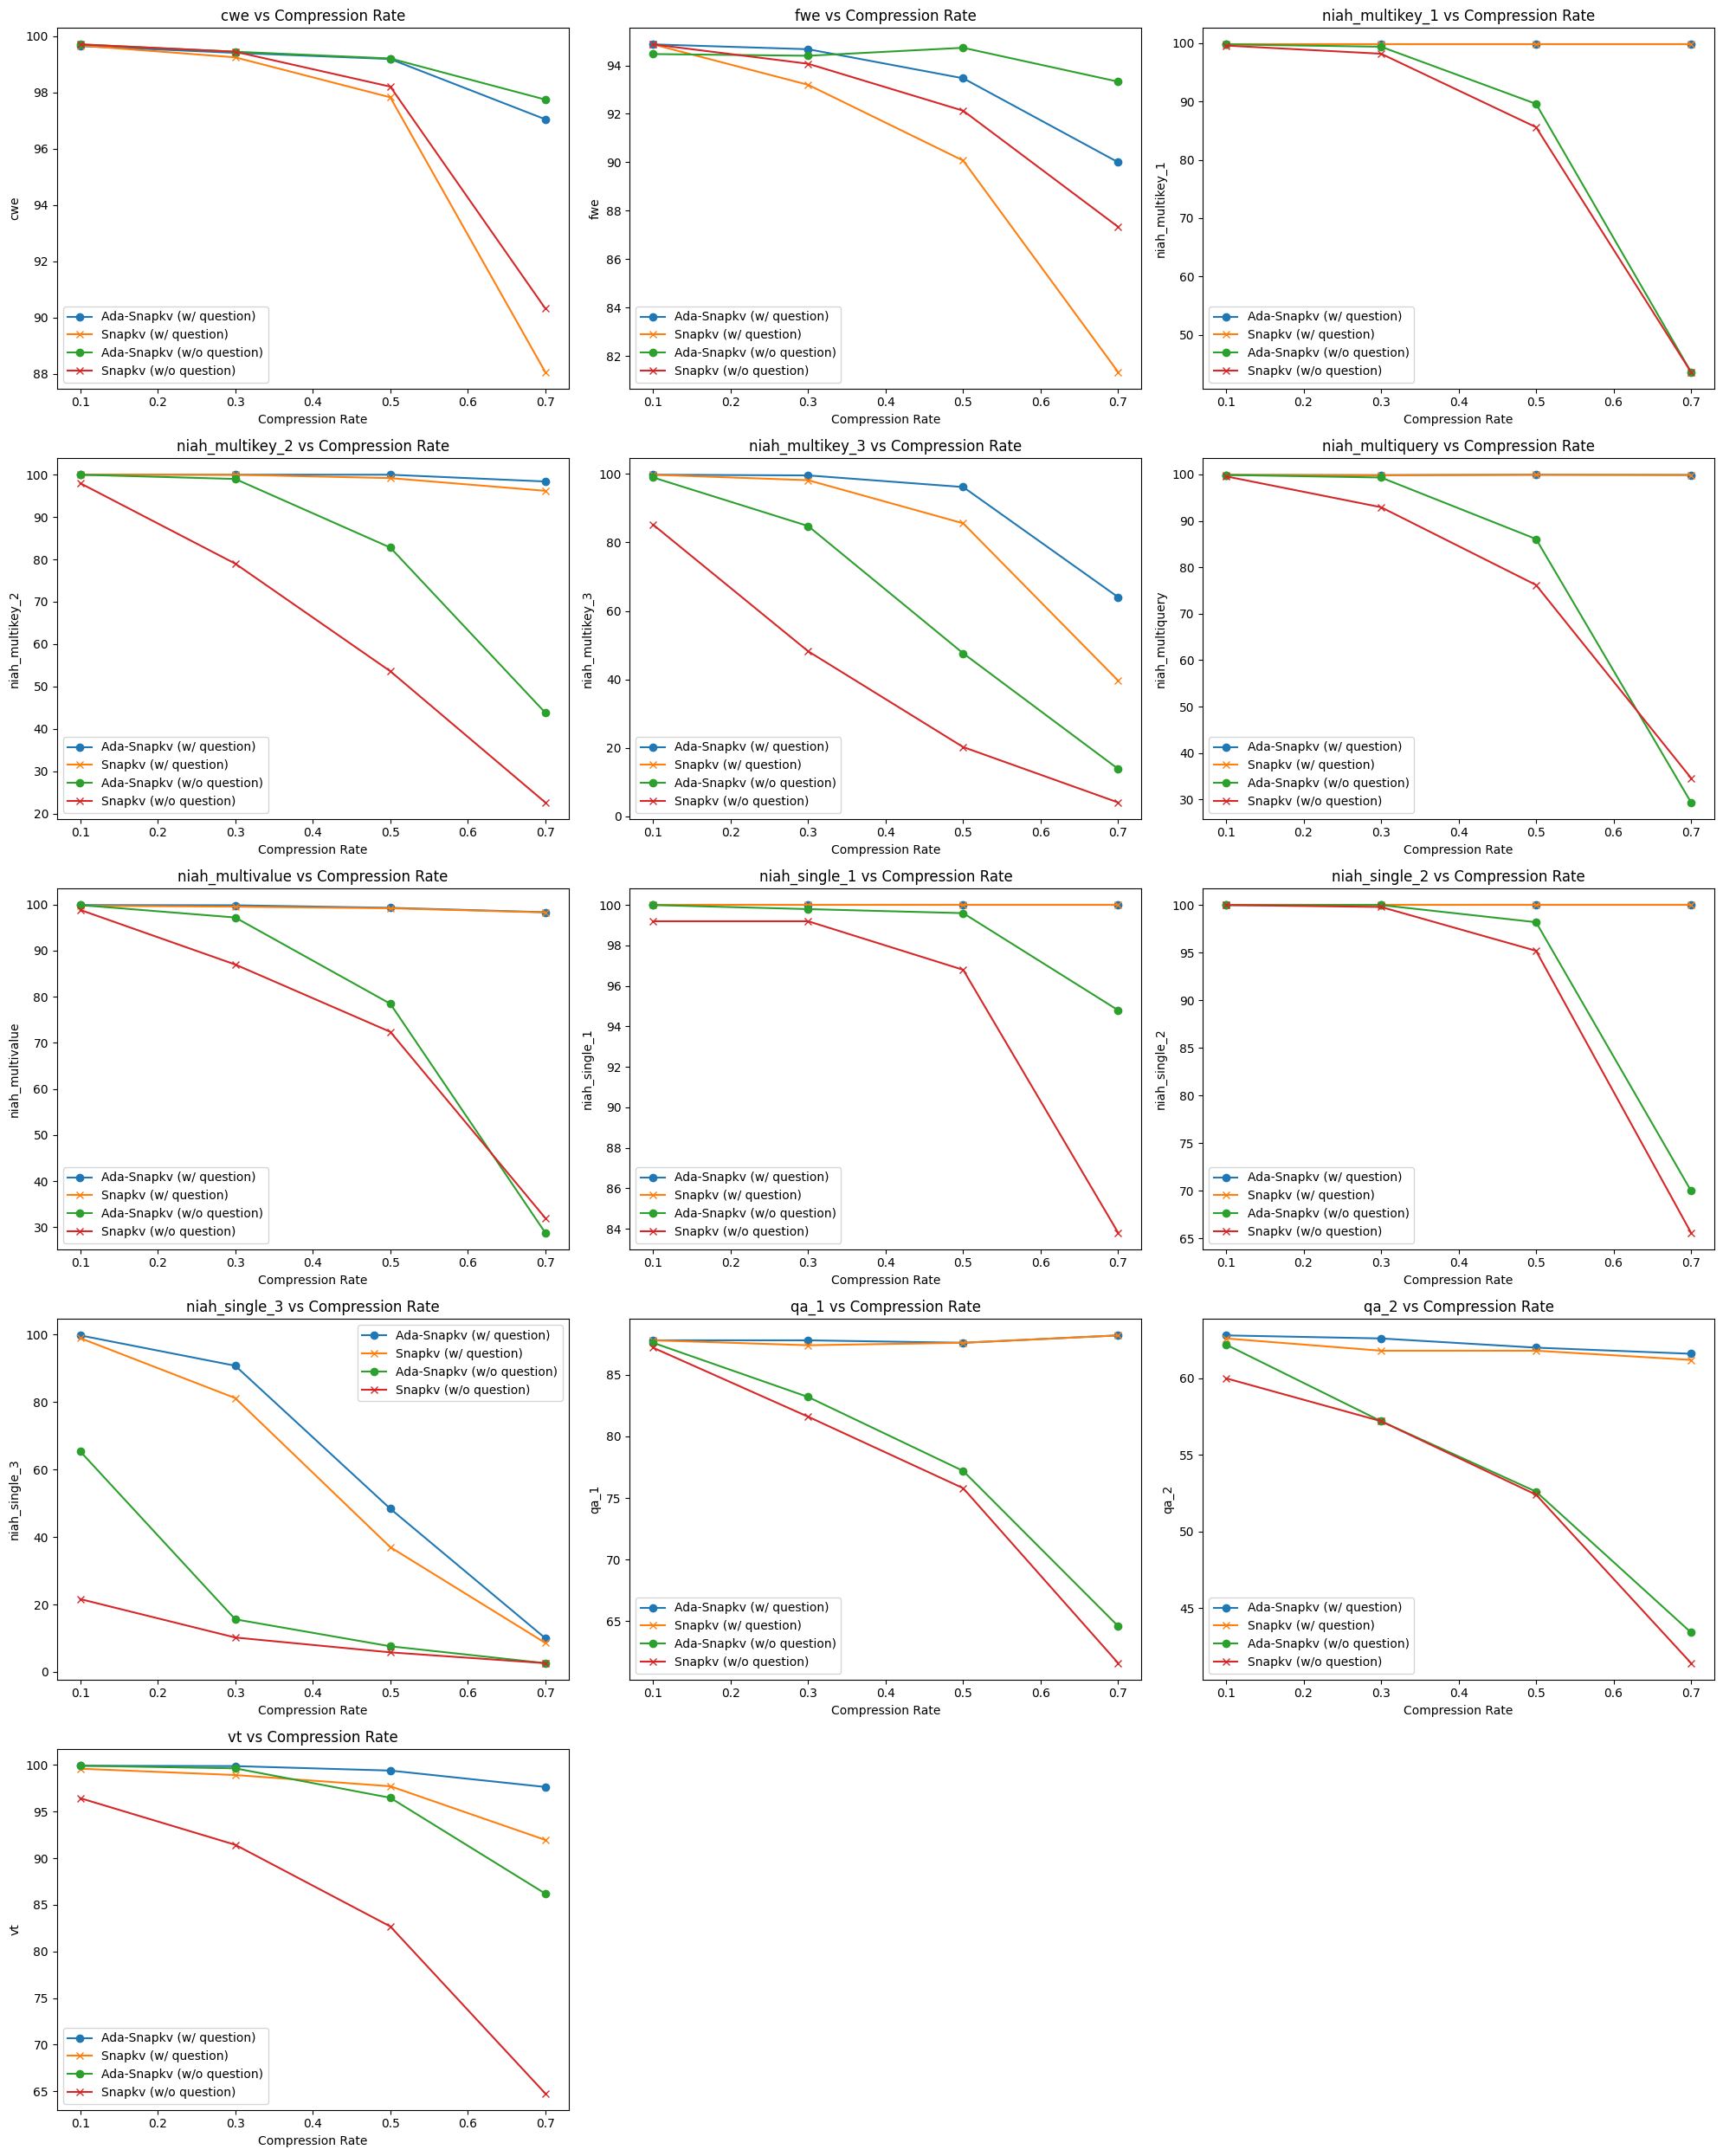

In [12]:
# all datasets
score_columns = [ 'cwe', 'fwe', 'niah_multikey_1', 'niah_multikey_2', 'niah_multikey_3',
                 'niah_multiquery', 'niah_multivalue', 'niah_single_1', 'niah_single_2', 
                 'niah_single_3', 'qa_1', 'qa_2', 'vt', ]

ncols = 3
nrows = (len(score_columns) + ncols - 1) // ncols  # 计算行数

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 5))

axes = axes.flatten()

for i, score_column in enumerate(score_columns):
    axes[i].plot(ada_snapekv_w_question['compression_rate'], ada_snapekv_w_question[score_column], label='Ada-Snapkv (w/ question)', marker='o')
    axes[i].plot(snapekv_w_question['compression_rate'], snapekv_w_question[score_column], label='Snapkv (w/ question)', marker='x')
    axes[i].plot(ada_snapekv_wo_question['compression_rate'], ada_snapekv_wo_question[score_column], label='Ada-Snapkv (w/o question)', marker='o')
    axes[i].plot(snapekv_wo_question['compression_rate'], snapekv_wo_question[score_column], label='Snapkv (w/o question)', marker='x')
    
    axes[i].set_title(f'{score_column} vs Compression Rate')
    axes[i].set_xlabel('Compression Rate')
    axes[i].set_ylabel(score_column)
    axes[i].legend()

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()